# Mount G-Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# All Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

## MNIST Dataset


# VGG16

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training logs saved to training_log_resnet18_mnist.txt


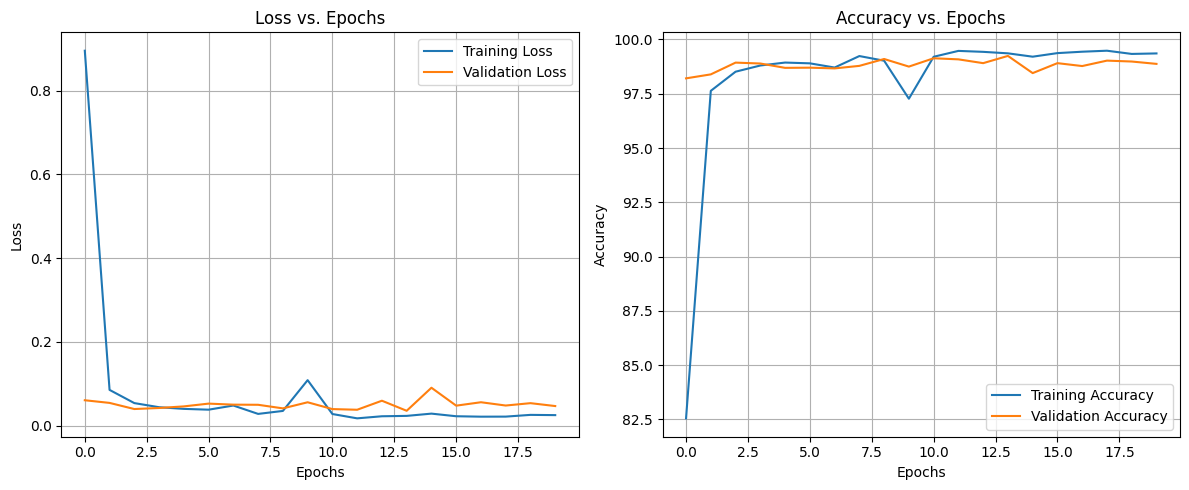

In [ ]:
# hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20 # Increased the number of epochs for better observation
val_split = 0.2  # Percentage of training data to use for validation

# 1. Data Loading and Preprocessing
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize MNIST images to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), # Mean and std for MNIST
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)) # Replicate grayscale channel to 3 channels
])

# Load the full MNIST dataset
full_dataset = datasets.MNIST(root='/content/drive/MyDrive/DLCV_MiniProject_Dataset', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='/content/drive/MyDrive/DLCV_MiniProject_Dataset', train=False, download=True, transform=transform)

# Split training data into training and validation sets
train_size = int((1 - val_split) * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Corrected this line to use val_loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. Model Implementation
model = models.vgg16(pretrained=False)

# Modify the first convolutional layer to accept 3 input channels
model.features[0] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# Number of output features from the convolutional layers
dummy_input = torch.randn(batch_size, 3, 224, 224)
with torch.no_grad():
    dummy_output = model.features(dummy_input)
    num_features = dummy_output.view(dummy_output.size(0), -1).shape[1]

# Modify the classifier
model.classifier = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 10),
)

# 3. Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check if CUDA is available and move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

log_file_path = 'training_log_vgg16_mnist.txt'

original_stdout = sys.stdout

with open(log_file_path, 'w') as f:
  sys.stdout = f
  # 4. Training Loop
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0
      for i, (inputs, labels) in enumerate(train_loader):
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()

          if (i + 1) % 100 == 0:
              print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

      avg_train_loss = running_loss / len(train_loader)
      train_accuracy = 100 * correct_train / total_train
      train_losses.append(avg_train_loss)
      train_accuracies.append(train_accuracy)
      #print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
      print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')


      model.eval()
      val_loss = 0.0
      correct_val = 0
      total_val = 0
      # Iterate through val_loader instead of val_dataset
      with torch.no_grad():
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted == labels).sum().item()

      avg_val_loss = val_loss / len(val_loader)
      val_accuracy = 100 * correct_val / total_val
      val_losses.append(avg_val_loss)
      val_accuracies.append(val_accuracy)
      #print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
      print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

  # 5. Evaluation on Test Set
  model.eval()
  correct_test = 0
  total_test = 0
  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total_test += labels.size(0)
          correct_test += (predicted == labels).sum().item()

  test_accuracy = 100 * correct_test / total_test
  print(f'Test Accuracy of VGG16 on MNIST: {test_accuracy:.2f}%')
  sys.stdout = original_stdout

print(f"Training logs saved to {log_file_path}")

# Plot graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ResNet18


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training logs saved to training_log_resnet18_mnist.txt


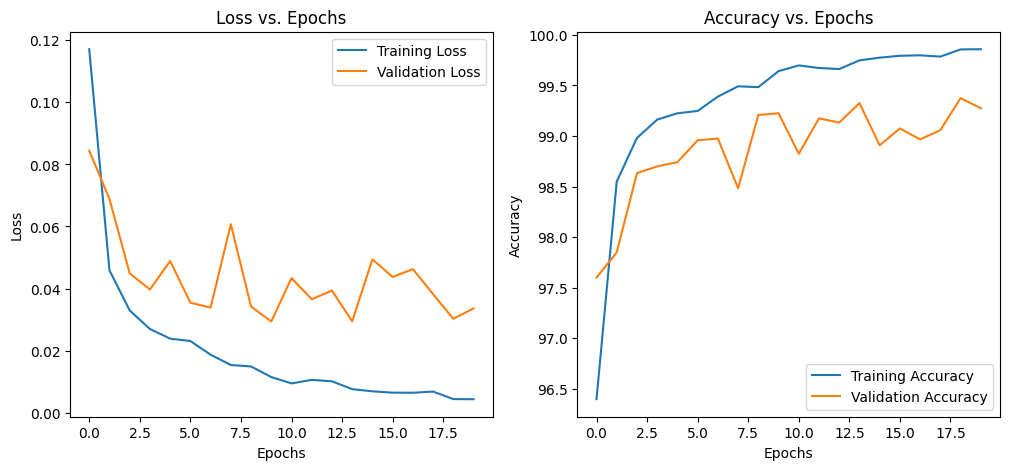

In [ ]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
val_split = 0.2

# 1. Data Loading and Preprocessing
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize MNIST images to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)) # Replicate grayscale channel to 3 channels
])

# Load the full MNIST dataset
full_dataset = datasets.MNIST(root='/content/drive/MyDrive/DLCV_MiniProject_Dataset', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='/content/drive/MyDrive/DLCV_MiniProject_Dataset', train=False, download=True, transform=transform)

# Split training data into training and validation sets
train_size = int((1 - val_split) * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. Model Implementation (ResNet18)
# Pre-trained ResNet18 model (without pre-trained weights)
model = models.resnet18(pretrained=False)

model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10) # Output size is 10 for MNIST classes

# 3. Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check if CUDA is available and move model to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

log_file_path = 'training_log_resnet18_mnist.txt'


original_stdout = sys.stdout

with open(log_file_path, 'w') as f:
  sys.stdout = f
  # 4. Training Loop
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0
      for i, (inputs, labels) in enumerate(train_loader):
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()

          if (i + 1) % 100 == 0:
              print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

      avg_train_loss = running_loss / len(train_loader)
      train_accuracy = 100 * correct_train / total_train
      train_losses.append(avg_train_loss)
      train_accuracies.append(train_accuracy)
      #print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
      print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')


      model.eval()
      val_loss = 0.0
      correct_val = 0
      total_val = 0
      with torch.no_grad():
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted == labels).sum().item()

      avg_val_loss = val_loss / len(val_loader)
      val_accuracy = 100 * correct_val / total_val
      val_losses.append(avg_val_loss)
      val_accuracies.append(val_accuracy)
      #print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
      print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

  # 5. Evaluation on Test Set
  model.eval()
  correct_test = 0
  total_test = 0
  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total_test += labels.size(0)
          correct_test += (predicted == labels).sum().item()

  test_accuracy = 100 * correct_test / total_test
  print(f'Test Accuracy of ResNet18 on MNIST: {test_accuracy:.2f}%')
  sys.stdout = original_stdout

print(f"Training logs saved to {log_file_path}")

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## CIFAR-10 Dataset

# VGG16

**Manual architecture**

Training logs saved to training_log_manual_vgg16_cifar10.txt


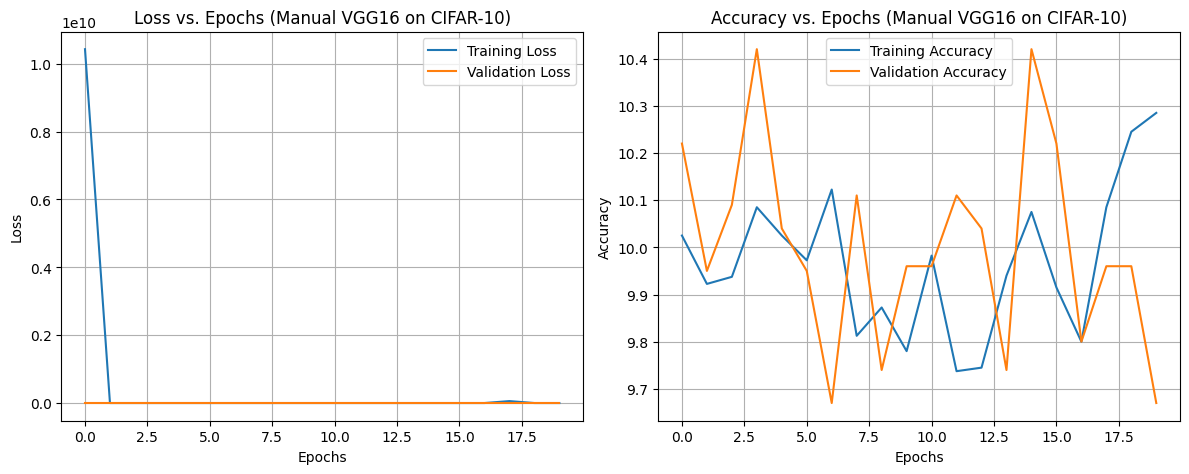

In [ ]:
# Hyperparameters
batch_size = 64
learning_rate = 0.01
num_epochs = 20
val_split = 0.2

# VGG16 Architecture
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

# VGG16 configuration
cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

class VGG16(nn.Module):
    def __init__(self, num_classes=10, init_weights=True):
        super(VGG16, self).__init__()
        self.features = make_layers(cfg, batch_norm=False)

        # I used a dummy input after defining features to find the size
        # The size after the last maxpool for 224x224 input is 7x7x512 = 25088
        # For 32x32 input resized to 224x224, it will also be 25088

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), # Input size based on 224x224 final feature map
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes), # Output size is 10 for CIFAR-10
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the output from features
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# 1. Data Loading and Preprocessing for CIFAR-10
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


dataset_root = '/content/drive/MyDrive/DLCV_MiniProject_Dataset/CIFAR10'
os.makedirs(dataset_root, exist_ok=True)

# Load the CIFAR-10 dataset
full_dataset = datasets.CIFAR10(root=dataset_root, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=dataset_root, train=False, download=True, transform=transform)

# Split training data into training and validation sets
train_size = int((1 - val_split) * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. Model Implementation
model = VGG16(num_classes=10)

# 3. Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check if CUDA is available and move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

log_file_path = 'training_log_manual_vgg16_cifar10.txt'


original_stdout = sys.stdout

with open(log_file_path, 'w') as f:
    sys.stdout = f
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Starting Manual VGG16 training on CIFAR-10...")
    print("-" * 50)


    # 4. Training Loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Epoch [{epoch+1}/{num_epochs}] Training starts...")

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()


            if (i + 1) % 100 == 0:
                 print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - Epoch [{epoch+1}/{num_epochs}] Training Summary: Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')


        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Epoch [{epoch+1}/{num_epochs}] Validation starts...")
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - Epoch [{epoch+1}/{num_epochs}] Validation Summary: Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
        print("-" * 50)

    # 5. Evaluation on Test Set
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Test evaluation starts...")
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test

    print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - Test Accuracy of Manual VGG16 on CIFAR-10: {test_accuracy:.2f}%')


    sys.stdout = original_stdout

print(f"Training logs saved to {log_file_path}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs (Manual VGG16 on CIFAR-10)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs (Manual VGG16 on CIFAR-10)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**With Transfer Learning**

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 232MB/s]


Training logs saved to training_log_pretrained_vgg16_cifar10.txt


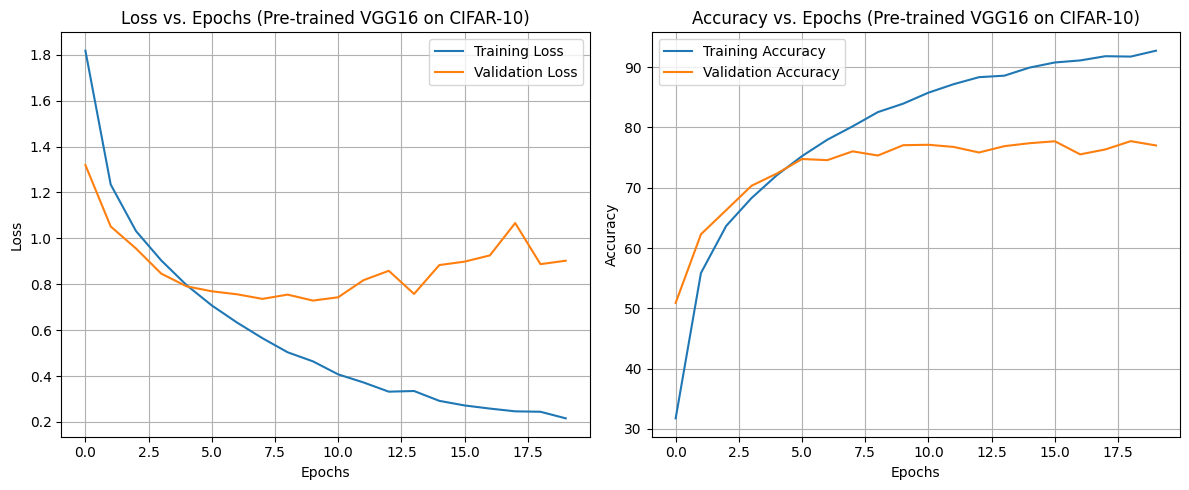

In [ ]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
val_split = 0.2

# 1. Data Loading and Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # I used ImageNet stats because the model was trained on ImageNet
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

dataset_root = '/content/drive/MyDrive/DLCV_MiniProject_Dataset/CIFAR10'
os.makedirs(dataset_root, exist_ok=True)

# Load the CIFAR-10 dataset
full_dataset = datasets.CIFAR10(root=dataset_root, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=dataset_root, train=False, download=True, transform=transform)

# Split training data into training and validation sets
train_size = int((1 - val_split) * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 2. Model Implementation (Pre-built VGG16 with Pre-trained Weights)
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze the parameters of the feature extractor
# for param in model.features.parameters():
#     param.requires_grad = False

# Modify the classifier
num_features = 512 * 7 * 7 # This is the flattened size after features for 224x224 input

model.classifier = nn.Sequential(
    nn.Linear(num_features, 512), # Reduced size for fine-tuning
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(512, 10),
)


# 3. Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

log_file_path = 'training_log_pretrained_vgg16_cifar10.txt'

original_stdout = sys.stdout

with open(log_file_path, 'w') as f:
    sys.stdout = f

    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Starting Pre-trained VGG16 training on CIFAR-10...")
    print("-" * 50)

    # 4. Training Loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Epoch [{epoch+1}/{num_epochs}] Training starts...")

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()


            if (i + 1) % 100 == 0:
                 print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - Epoch [{epoch+1}/{num_epochs}] Training Summary: Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')


        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Epoch [{epoch+1}/{num_epochs}] Validation starts...")
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - Epoch [{epoch+1}/{num_epochs}] Validation Summary: Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
        print("-" * 50)

    # 5. Evaluation on Test Set
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Test evaluation starts...")
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test

    print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - Test Accuracy of Pre-trained VGG16 on CIFAR-10: {test_accuracy:.2f}%')


    sys.stdout = original_stdout


print(f"Training logs saved to {log_file_path}")

# Plot graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs (Pre-trained VGG16 on CIFAR-10)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs (Pre-trained VGG16 on CIFAR-10)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Modified version of transfer learning**

Training logs saved to training_log_enhanced_vgg16_cifar10.txt


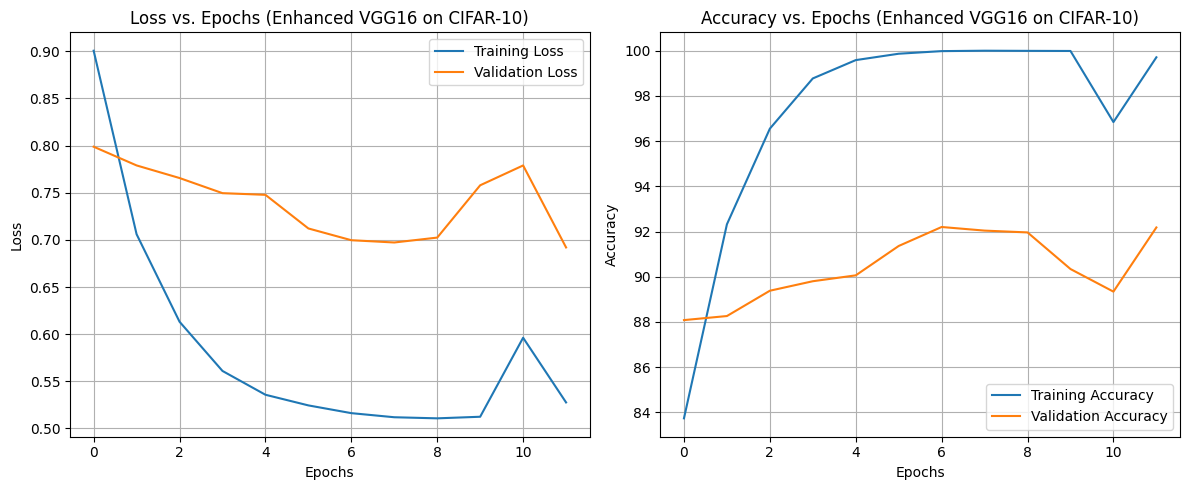

In [ ]:
# Enhanced hyperparameters
batch_size = 128
learning_rate = 0.0005
num_epochs = 50
val_split = 0.1
weight_decay = 1e-4

# Enhanced data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


dataset_root = '/content/drive/MyDrive/DLCV_MiniProject_Dataset/CIFAR10'
os.makedirs(dataset_root, exist_ok=True)

full_dataset = datasets.CIFAR10(root=dataset_root, train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root=dataset_root, train=False, download=True, transform=test_transform)


train_size = int((1 - val_split) * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


val_dataset.dataset.transform = test_transform


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Enhanced model setup
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze early layers initially
for param in model.features[:24].parameters():  # Freeze first 4 blocks
    param.requires_grad = False

# Enhanced classifier
model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(1024, 10)
)


criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate schedulers
# Using ReduceLROnPlateau.
scheduler_reduce_lr = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)


# Early stopping
best_val_accuracy = 0
patience = 5
patience_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

log_file_path = 'training_log_enhanced_vgg16_cifar10.txt'

original_stdout = sys.stdout

with open(log_file_path, 'w') as f:
    sys.stdout = f
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Starting Enhanced VGG16 training on CIFAR-10...")
    print("-" * 50)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Gradually unfreeze layers
        if epoch == 10:
            print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Unfreezing feature layers from block 4 onwards...")
            for param in model.features[24:].parameters():
                param.requires_grad = True

        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Epoch [{epoch+1}/{num_epochs}] Training starts...")

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train


        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)


        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_loss = val_loss / len(val_loader)


        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        scheduler_reduce_lr.step(val_accuracy)


        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Current Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 50)


        # Early stopping check
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_vgg16_cifar10.pth')
            print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Saved best model with Val Acc: {best_val_accuracy:.2f}%")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Early stopping triggered at epoch {epoch+1}")
                break

    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Training finished.")
    # Load best model for final evaluation
    if os.path.exists('best_vgg16_cifar10.pth'):
        model.load_state_dict(torch.load('best_vgg16_cifar10.pth'))
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Loaded best model for testing.")
    else:
         print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Best model not found. Using the last trained model.")


    # 5. Evaluation on Test Set
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Test evaluation starts...")
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Final Test Accuracy: {test_accuracy:.2f}%")

    sys.stdout = original_stdout

print(f"Training logs saved to {log_file_path}")

# Plot graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs (Enhanced VGG16 on CIFAR-10)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs (Enhanced VGG16 on CIFAR-10)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# For ResNet18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s]


Training logs saved to training_log_enhanced_resnet18_cifar10.txt


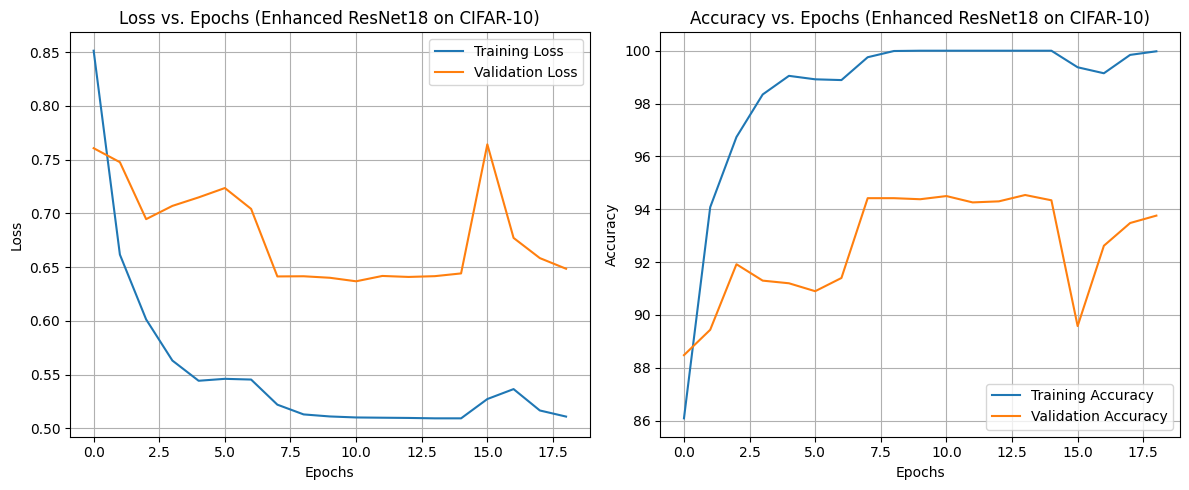

In [ ]:
# Hyperparameters
batch_size = 128
learning_rate = 0.0005
num_epochs = 50
val_split = 0.1
weight_decay = 1e-4

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

dataset_root = '/content/drive/MyDrive/DLCV_MiniProject_Dataset/CIFAR10'
os.makedirs(dataset_root, exist_ok=True)

full_dataset = datasets.CIFAR10(root=dataset_root, train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root=dataset_root, train=False, download=True, transform=test_transform)

train_size = int((1 - val_split) * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

val_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


# Load pre-trained ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze early layers initially
for param in model.conv1.parameters():
    param.requires_grad = False
for param in model.bn1.parameters():
    param.requires_grad = False
for param in model.layer1.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)


# Loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate schedulers
scheduler_reduce_lr = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)


# Early stopping
best_val_accuracy = 0
patience = 5
patience_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

log_file_path = 'training_log_enhanced_resnet18_cifar10.txt'

original_stdout = sys.stdout

with open(log_file_path, 'w') as f:
    sys.stdout = f
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Starting Enhanced ResNet18 training on CIFAR-10...")
    print("-" * 50)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0


        # Unfreeze layer2, layer3, layer4 after epoch 10
        if epoch == 10:
            print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Unfreezing layers from layer2 onwards...")
            for param in model.layer2.parameters():
                param.requires_grad = True
            for param in model.layer3.parameters():
                param.requires_grad = True
            for param in model.layer4.parameters():
                param.requires_grad = True


        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Epoch [{epoch+1}/{num_epochs}] Training starts...")

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()


        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)


        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_loss = val_loss / len(val_loader)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        scheduler_reduce_lr.step(val_accuracy)

        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Current Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 50)


        # Early stopping check
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_resnet18_cifar10.pth')
            print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Saved best model with Val Acc: {best_val_accuracy:.2f}%")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Early stopping triggered at epoch {epoch+1}")
                break

    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Training finished.")
    # Load best model for final evaluation
    if os.path.exists('best_resnet18_cifar10.pth'):
        model.load_state_dict(torch.load('best_resnet18_cifar10.pth'))
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Loaded best model for testing.")
    else:
         print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Best model not found. Using the last trained model.")


    # 5. Evaluation on Test Set
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Test evaluation starts...")
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Final Test Accuracy: {test_accuracy:.2f}%")

    sys.stdout = original_stdout

print(f"Training logs saved to {log_file_path}")

# Plot graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs (Enhanced ResNet18 on CIFAR-10)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs (Enhanced ResNet18 on CIFAR-10)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()